In [1]:
!nvidia-smi

Tue Jul 23 01:30:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:18:00.0 Off |                    0 |
| N/A   32C    P0             42W /  300W |       0MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install --upgrade pip
!pip install scikit-learn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.1
    Uninstalling pip-24.1.1:
      Successfully uninstalled pip-24.1.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 56.8 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 101.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 9.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 144.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 107.1 MB/s eta 0:00:

In [3]:
import os
import torch

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = []
        self.transform = transform

        self._load_data()

    def _load_data(self):
        for root, dirs, files in os.walk(self.data_dir):
            for dir_name in dirs[:]: 
                if dir_name == 'Unlabeled':
                    dirs.remove(dir_name)  # Skip 'Unlabeled' directory
                    continue

                class_dir = os.path.join(root, dir_name)
                class_label = dir_name

                if class_label not in self.label_to_idx:
                    self.label_to_idx[class_label] = len(self.idx_to_label)
                    self.idx_to_label.append(class_label)
                class_idx = self.label_to_idx[class_label]

                for file in os.listdir(class_dir):
                    if file.endswith((".jpg", ".png", ".jpeg")):
                        image_path = os.path.join(class_dir, file)
                        self.images.append(image_path)
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("L")  # Convert image to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

    def map_labels(self):
        return list(self.label_to_idx.keys())


train_image_dir='material-3/train'
valid_image_dir='material-3/valid'

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
transform = transforms.Compose([

    transforms.Resize((1024,1024)),

      transforms.ToTensor(), 

    transforms.Normalize(mean=[0.5],std=[0.5])
])
# Create datasets
train_dataset = CustomDataset(train_image_dir,transform=transform)
valid_dataset = CustomDataset(valid_image_dir,transform=transform)
#custom collate function

def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)
    return images, labels

#create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=40, shuffle=True, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, num_workers=40, shuffle=False, collate_fn=custom_collate_fn)
#train_loader = DataLoader(valid_dataset, batch_size=2, num_workers=4, shuffle=False, collate_fn=custom_collate_fn)

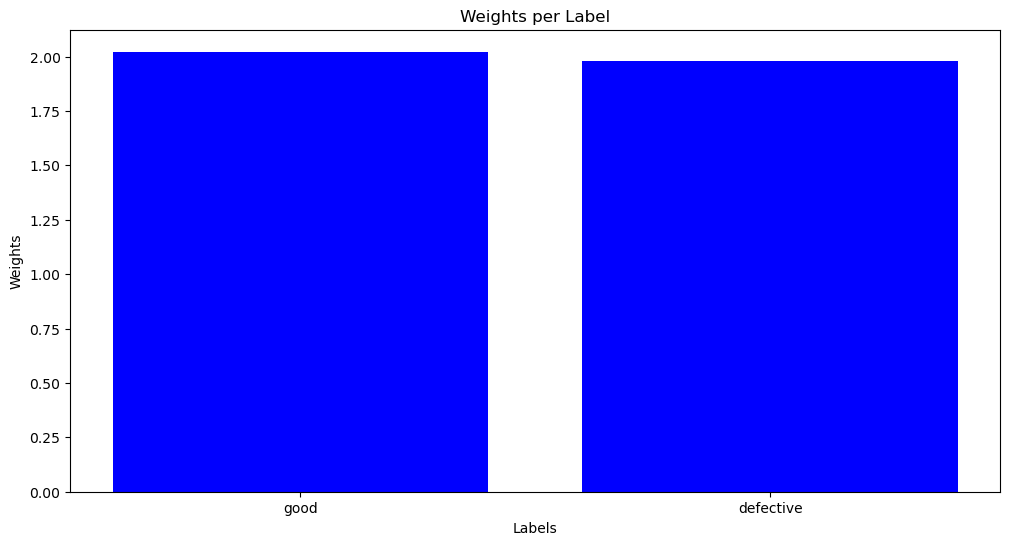

In [5]:
from collections import defaultdict
import torch
import numpy as np
import torch
import matplotlib.pyplot as plt


def extract_weights(train_dataset):
    class_counts = defaultdict(int)
    for idx in range(len(train_dataset)):
        _, label = train_dataset[idx]
        class_counts[label] += 1

    total_samples = sum(class_counts.values())

    weights = {label: total_samples / count for label, count in class_counts.items()}

    weights_list = [weights[label] for label in sorted(weights)]

    weights_array = np.array(weights_list)
    normalized_weights = weights_array / weights_array.sum()
    plt.figure(figsize=(12,6))
    plt.bar(train_dataset.map_labels(),list(weights.values()),color='b')
    plt.xlabel('Labels')
    plt.ylabel('Weights')
    plt.title('Weights per Label')
    plt.show()

    return torch.FloatTensor(normalized_weights)

class_weights = extract_weights(train_dataset)

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()

        # Load ResNet152 and remove the last two layers (global average pooling and FC)
        resnet = models.resnet152(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Adjusted for 1 channel

        self.resnet = nn.Sequential(*list(resnet.children())[:-2])

        # Load Xception and remove the last two layers (global average pooling and FC)
        xception = timm.create_model('xception', pretrained=True)
        xception.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # Adjusted for 1 channel

        self.xception = nn.Sequential(*list(xception.children())[:-2])

        # Convolutional layer to reduce the spatial dimensions
        self.conv_reduce = nn.Conv2d(4096, 2048, kernel_size=3, stride=2, padding=1)

        # Coordinate Attention module
        self.coord_att = CoordAtt(2048)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(2048 * 16* 16, 512)  # Adjusted input size
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):


        resnet_features = self.resnet(x)
        xception_features = self.xception(x)
        concat_features = torch.cat((resnet_features, xception_features), dim=1)

        reduced_features = self.conv_reduce(concat_features)
        coord_att_features = self.coord_att(reduced_features)
      #  print("coord size:", coord_att_features.size())

        flatten_features = self.flatten(coord_att_features)
       # print("flatten size:", flatten_features.size())
        x = self.fc1(flatten_features)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)

        return x

class CoordAtt(nn.Module):
    def __init__(self, inp, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((16, 1))  # Adjusted pooling size
        self.pool_w = nn.AdaptiveAvgPool2d((1, 16))  # Adjusted pooling size
        mip = max(8, inp // reduction)
        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)  # Adjusted input channels
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.ReLU(inplace=True)
        self.conv_h = nn.Conv2d(mip, inp, kernel_size=1, stride=1, padding=0)  # Adjusted output channels
        self.conv_w = nn.Conv2d(mip, inp, kernel_size=1, stride=1, padding=0)  # Adjusted output channels

    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)



        # Adjust split sizes to match the actual size after pooling and convolution
        x_h, x_w = torch.split(y, [16, 16], dim=2) 
        x_w = x_w.permute(0, 1, 3, 2)
        a_h = self.conv_h(x_h)


        a_w = self.conv_w(x_w)
        out = identity * a_h.sigmoid() * a_w.sigmoid()

        return out


model = HybridModel(num_classes=2)
model = nn.DataParallel(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/ucloud/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 239MB/s] 
/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading:

Epoch [1/6], Loss: 0.1517, Time: 491.18 seconds
Epoch: 1 Precision: 0.9986, Recall: 0.9986, F1 Score: 0.9986, Loss: 0.04183720918065244
Confusion Matrix:
[[305   0]
 [  1 422]]


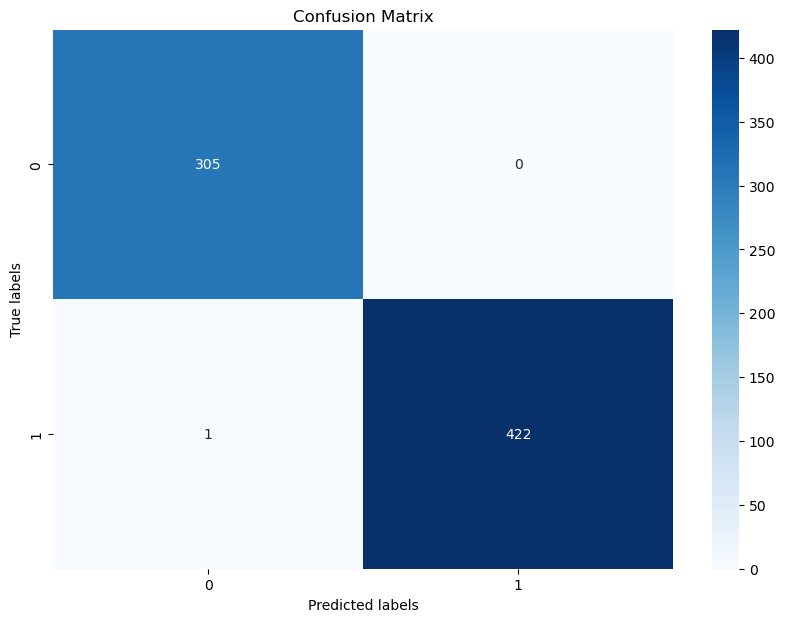

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/6], Loss: 0.0122, Time: 487.12 seconds
Epoch: 2 Precision: 0.9986, Recall: 0.9986, F1 Score: 0.9986, Loss: 0.0073344017013020416
Confusion Matrix:
[[304   1]
 [  0 423]]


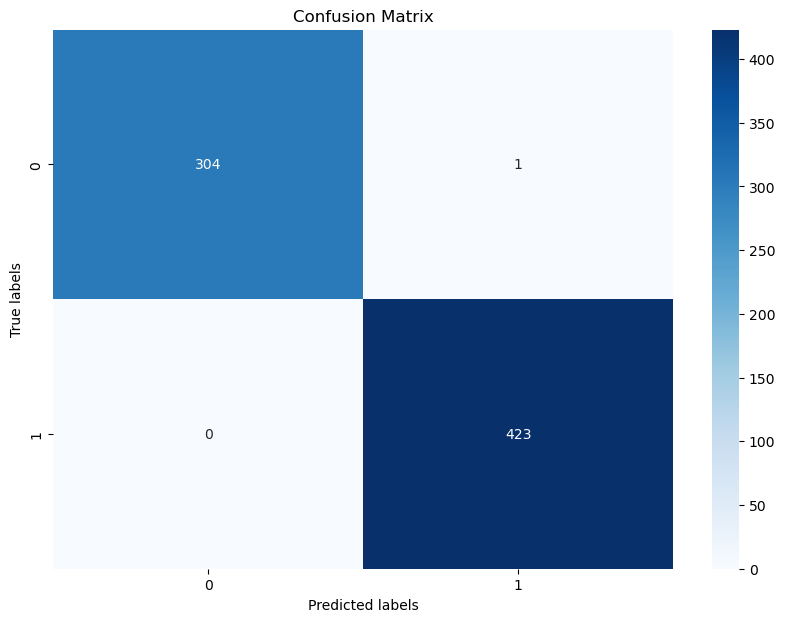

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [3/6], Loss: 0.0039, Time: 486.05 seconds
Epoch: 3 Precision: 0.9986, Recall: 0.9986, F1 Score: 0.9986, Loss: 0.0020625322195022117
Confusion Matrix:
[[305   0]
 [  1 422]]


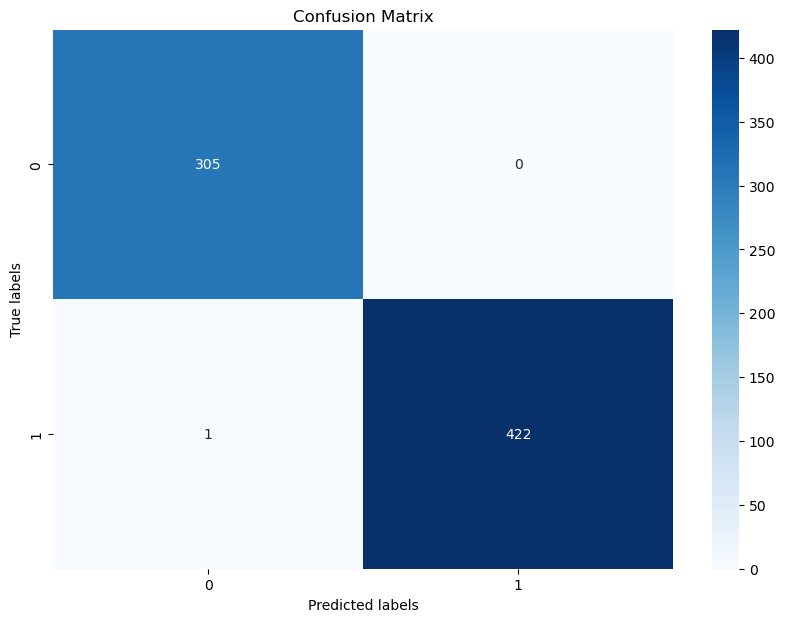

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [4/6], Loss: 0.0017, Time: 485.51 seconds
Epoch: 4 Precision: 0.9973, Recall: 0.9973, F1 Score: 0.9973, Loss: 0.006521184929036105
Confusion Matrix:
[[305   0]
 [  2 421]]


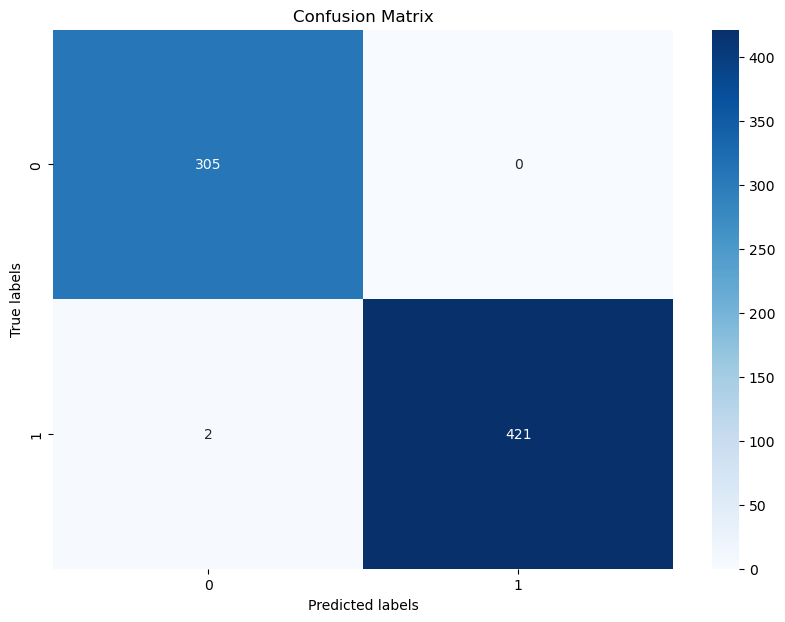

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [5/6], Loss: 0.0000, Time: 484.94 seconds
Epoch: 5 Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Loss: 0.0013510457899372432
Confusion Matrix:
[[305   0]
 [  0 423]]


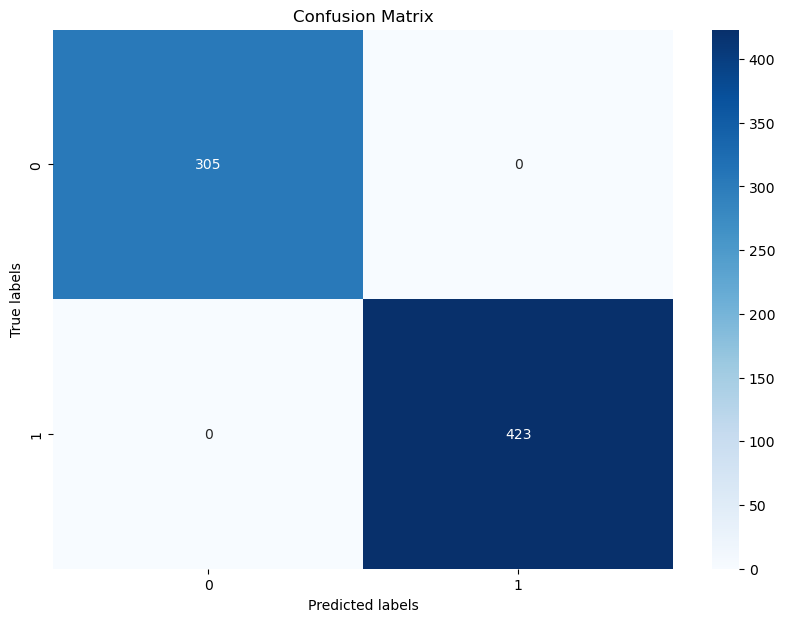

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [6/6], Loss: 0.0000, Time: 485.70 seconds
Epoch: 6 Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Loss: 0.0012054424256796043
Confusion Matrix:
[[305   0]
 [  0 423]]


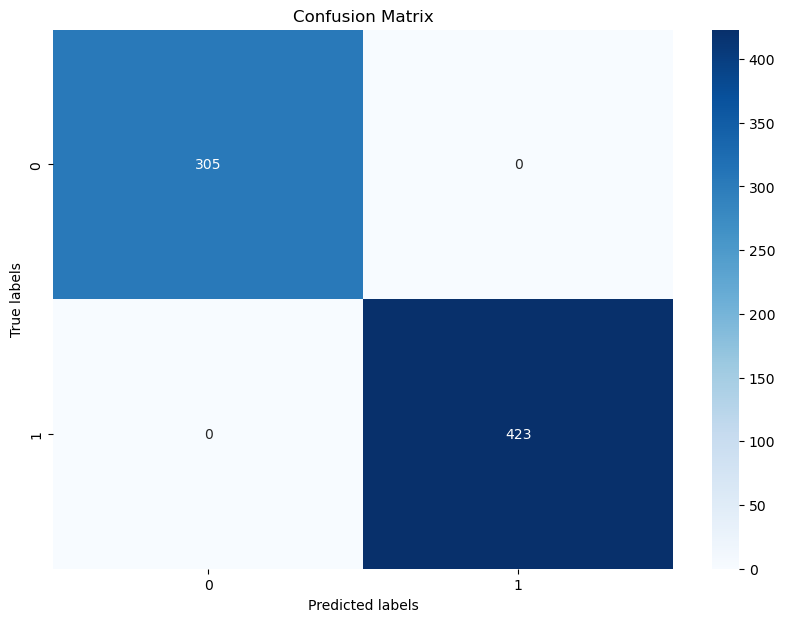

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [8]:
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau,OneCycleLR

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Trainer:
    def __init__(self, model, train_loader, valid_loader, criterion, optimizer, scheduler, scaler):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scaler = scaler
        self.early_stop = 0
        self.patience = 3
        self.best_loss = float('inf')

    def train_model(self, num_epochs):
        self.model.to(device)
        self.model.train()
        history = []
        lr = []

        for epoch in range(num_epochs):
            start_time = time.time()
            running_loss = 0.0
            predicted_labels = []
            true_labels = []
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}", leave=False)

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                with autocast():
                    logits = self.model(inputs)
                    loss = self.criterion(logits, labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                running_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                progress_bar.set_postfix(loss=running_loss / len(progress_bar))

            validator_loss, metrics = self.validate_model(self.model, self.valid_loader)
            torch.cuda.empty_cache()

            precision, recall, f1 = metrics['precision'], metrics['recall'], metrics['f1']

            epoch_time = time.time() - start_time
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}, Time: {epoch_time:.2f} seconds")
            print(f'Epoch: {epoch + 1} Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Loss: {validator_loss}')
            print("Confusion Matrix:")
            print(metrics['confusion_matrix'])
            self.plot_matrix(metrics['confusion_matrix'])

            history.append({
                'Epoch': epoch + 1,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'Loss': validator_loss
            })

            if validator_loss < self.best_loss:
                self.best_loss = validator_loss
                torch.save(self.model.state_dict(), 'runs1/best.pt') # Save the best model state
                self.early_stop = 0
            else:
                self.early_stop += 1

            if self.early_stop >= self.patience:
                print("Early stopping triggered")
                break

            self.scheduler.step(validator_loss)
            lr.append(self.scheduler.optimizer.param_groups[0]['lr']) 

        self.metrics_to_csv(history, filename='runs1/metrics.csv') 
        torch.save(self.model.state_dict(), 'runs1/final.pt')  # Save the final model state

    def validate_model(self, model, valid_loader):
        model.eval()
        device = next(model.parameters()).device
        predicted_labels = []
        true_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)

                loss = self.criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits, 1)
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(valid_loader.dataset)
        metrics = self.compute_metrics(true_labels, predicted_labels)
        return val_loss, metrics

    def compute_metrics(self, true_labels, predicted_labels):
        metrics = {}
        metrics['confusion_matrix'] = confusion_matrix(true_labels, predicted_labels)
        p, r, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
        metrics['precision'] = p
        metrics['recall'] = r
        metrics['f1'] = f1
        return metrics

    def plot_matrix(self, conf_matrix):
        df_cm = pd.DataFrame(conf_matrix, index=range(len(conf_matrix)), columns=range(len(conf_matrix)))
        plt.figure(figsize=(10, 7))
        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', cbar=True, xticklabels=df_cm.columns, yticklabels=df_cm.index)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    def metrics_to_csv(self, history, filename='runs/metrics.csv'):
        df = pd.DataFrame(history, columns=['Epoch', 'Precision', 'Recall', 'F1 Score', 'Loss'])
        df.to_csv(filename, index=False)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_loader), epochs=6, anneal_strategy='linear')
scaler = GradScaler()

trainer = Trainer(model, train_loader, valid_loader, criterion, optimizer, scheduler, scaler)
trainer.train_model(6)